In [1]:
import warnings
from importlib import reload
from functools import partial, lru_cache

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm, trange
from joblib import delayed
from modAL import batch
from art.metrics import empirical_robustness
from art.attacks.evasion import *
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from tabulate import tabulate
from art.estimators.classification.scikitlearn import ScikitlearnSVC
from sklearn.metrics.pairwise import paired_distances, euclidean_distances
import scipy

from ipynb.fs.defs import Bias
from ipynb.fs.defs.Datasets import generateData_twoPills_2D, generateData_twoPills_noNoise_2D, plot_dataset_2D

import libactive
import libadversarial
from libactive import MyActiveLearner, active_split
from libadversarial import adversarial, uncertainty, random_batch
from libutil import ProgressParallel
from libdatasets import *
import librun
from librun import run

Using sklearn


In [15]:
matrix = {
    # Dataset fetchers should cache if possible
    # Lambda wrapper required for function to be pickleable (sent to other threads via joblib)
    "datasets": [
        ("mnist", lambda: lru_cache()(mnist)()),
    ],
    "dataset_mutators": {
        "none": (lambda *x: x),
    },
    "methods": [
        ("random", partial(random_batch, n_instances=10)),
        ("uncertainty", partial(batch.uncertainty_batch_sampling, n_instances=10)),
        ("deepfool", partial(adversarial, Attack=partial(DeepFool, verbose=False), n_instances=10)),
    ],
    "models": [
        "svm-linear"
    ],
    "meta": {
        "dataset_size": 1000,
        "labelled_size": 0.1,
        "n_runs": 10
    }
}

In [17]:
results = librun.run(matrix)

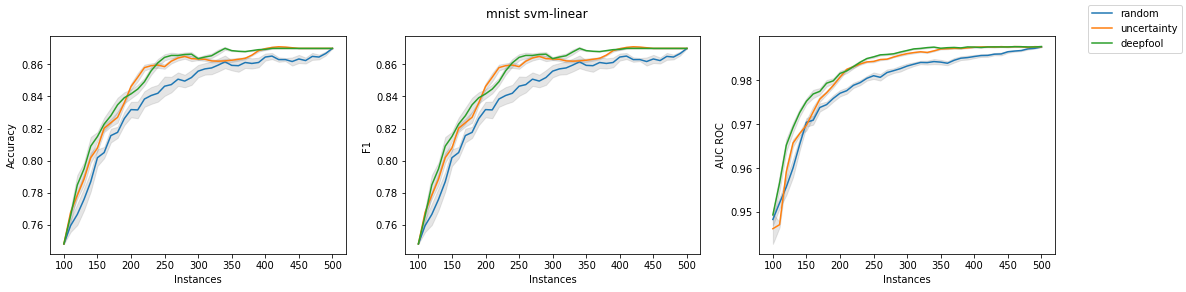

In [7]:
librun.plot(results)

In [11]:
[c[1]['roc_auc_score'][0] for c in results]

[0.9483038008509836, 0.9462062692871294, 0.9493471444246003]

In [18]:
librun.table(results)

mnist
╒═════════════╤═══════════╤════════════╤═══════════════╤═════════════════════════════╤════════════════════════════╤════════════╕
│ method      │ AUC LAC   │ AUC LF1C   │ AUC AUC ROC   │ Instances to max accuracy   │ Instances to max AUC ROC   │       Time │
╞═════════════╪═══════════╪════════════╪═══════════════╪═════════════════════════════╪════════════════════════════╪════════════╡
│ uncertainty │ 1.02±0    │ 1.02±0     │ 1.00±0        │ 400±0                       │ 430±20                     │     3.9822 │
├─────────────┼───────────┼────────────┼───────────────┼─────────────────────────────┼────────────────────────────┼────────────┤
│ deepfool    │ 1.02±0    │ 1.02±0     │ 1.00±0        │ 340±0                       │ 500±70                     │ 23772      │
├─────────────┼───────────┼────────────┼───────────────┼─────────────────────────────┼────────────────────────────┼────────────┤
│ random      │ 1.00±0    │ 1.00±0     │ 1.00±0        │ 500±0                       │ 500±